#Imports

In [ ]:
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications import MobileNetV2
from keras.applications import ResNet50, InceptionV3
from keras.applications.mobilenet_v2 import preprocess_input as mobilepre
from keras.applications.vgg16 import preprocess_input as vggpre
from keras.applications.resnet50 import preprocess_input as respre
from keras.applications.inception_v3 import preprocess_input as inc3
from keras.layers import Dense , GlobalAveragePooling2D
from keras.models import Model
from keras.metrics import F1Score
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import os

#Loading Dataset

In [ ]:
!gdown 1O4YR4UBatOLnaP4gMHbmFw7UJvhhxFwq
!gdown 1-7aMdKW4KcCKLwoUKC3XxdIwfIKkzwx6

Downloading...
From: https://drive.google.com/uc?id=1O4YR4UBatOLnaP4gMHbmFw7UJvhhxFwq
To: /content/train_data.zip
100% 173M/173M [00:02<00:00, 74.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-7aMdKW4KcCKLwoUKC3XxdIwfIKkzwx6
To: /content/test_data.zip
100% 73.0M/73.0M [00:01<00:00, 44.1MB/s]


In [ ]:
!unzip 'test_data.zip'
!unzip 'train_data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train_data/10/fac187c69fc74a48d28e626bd17fe5b0d36db1e6_1618836534.jpg  
  inflating: train_data/10/9a9f9ff4d3dcfc88e6b9209178d4ee791142fdaa_1618725283.jpg  
  inflating: train_data/10/958281d27ab722113c92180afe17db62bfb6a5d0_1623743398.jpg  
  inflating: train_data/10/8a94fada61bcb6dda8983dc36ddf2ec5d32cbf9f_1629199040.jpg  
  inflating: train_data/10/d72c1b799a927514b1fd81d9ee93208734be4d61_1613975034.jpg  
  inflating: train_data/10/6550a6492a93a9542b7757c898369f7996bb62b7_1613978514.jpg  
  inflating: train_data/10/3465c07dc8a3521f0303cec03ebbc4ac2d738317_1630174913.jpg  
  inflating: train_data/10/74a657eb2f8bc1a9bcd42fee32d04b1a400fcddf_1627746721.jpg  
  inflating: train_data/10/387c4a5ef5d37c263ebe457a2aab08890da843ca_1620800188.jpg  
  inflating: train_data/10/01330eb299562e0e10bdc560e7ed12754f49703b_1621081068.jpg  
  inflating: train_data/10/1ea75672aea3496a099cc3c8d8e2c01306456a52_1619644153.jpg  
  inflating: t

In [ ]:
root = 'train_data'
train_dataset = keras.utils.image_dataset_from_directory(root , validation_split= 0.2 , seed = 42 , image_size = (224 ,224) , subset = 'training' , batch_size = 32, interpolation="nearest", color_mode="rgb")

Found 9990 files belonging to 10 classes.
Using 7992 files for training.


In [ ]:
validation_dataset = keras.utils.image_dataset_from_directory(root, validation_split = 0.2 , image_size = (224 ,224), seed = 42 , subset ='validation', batch_size = 32, interpolation="nearest", color_mode="rgb")
validation_dataset

Found 9990 files belonging to 10 classes.
Using 1998 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

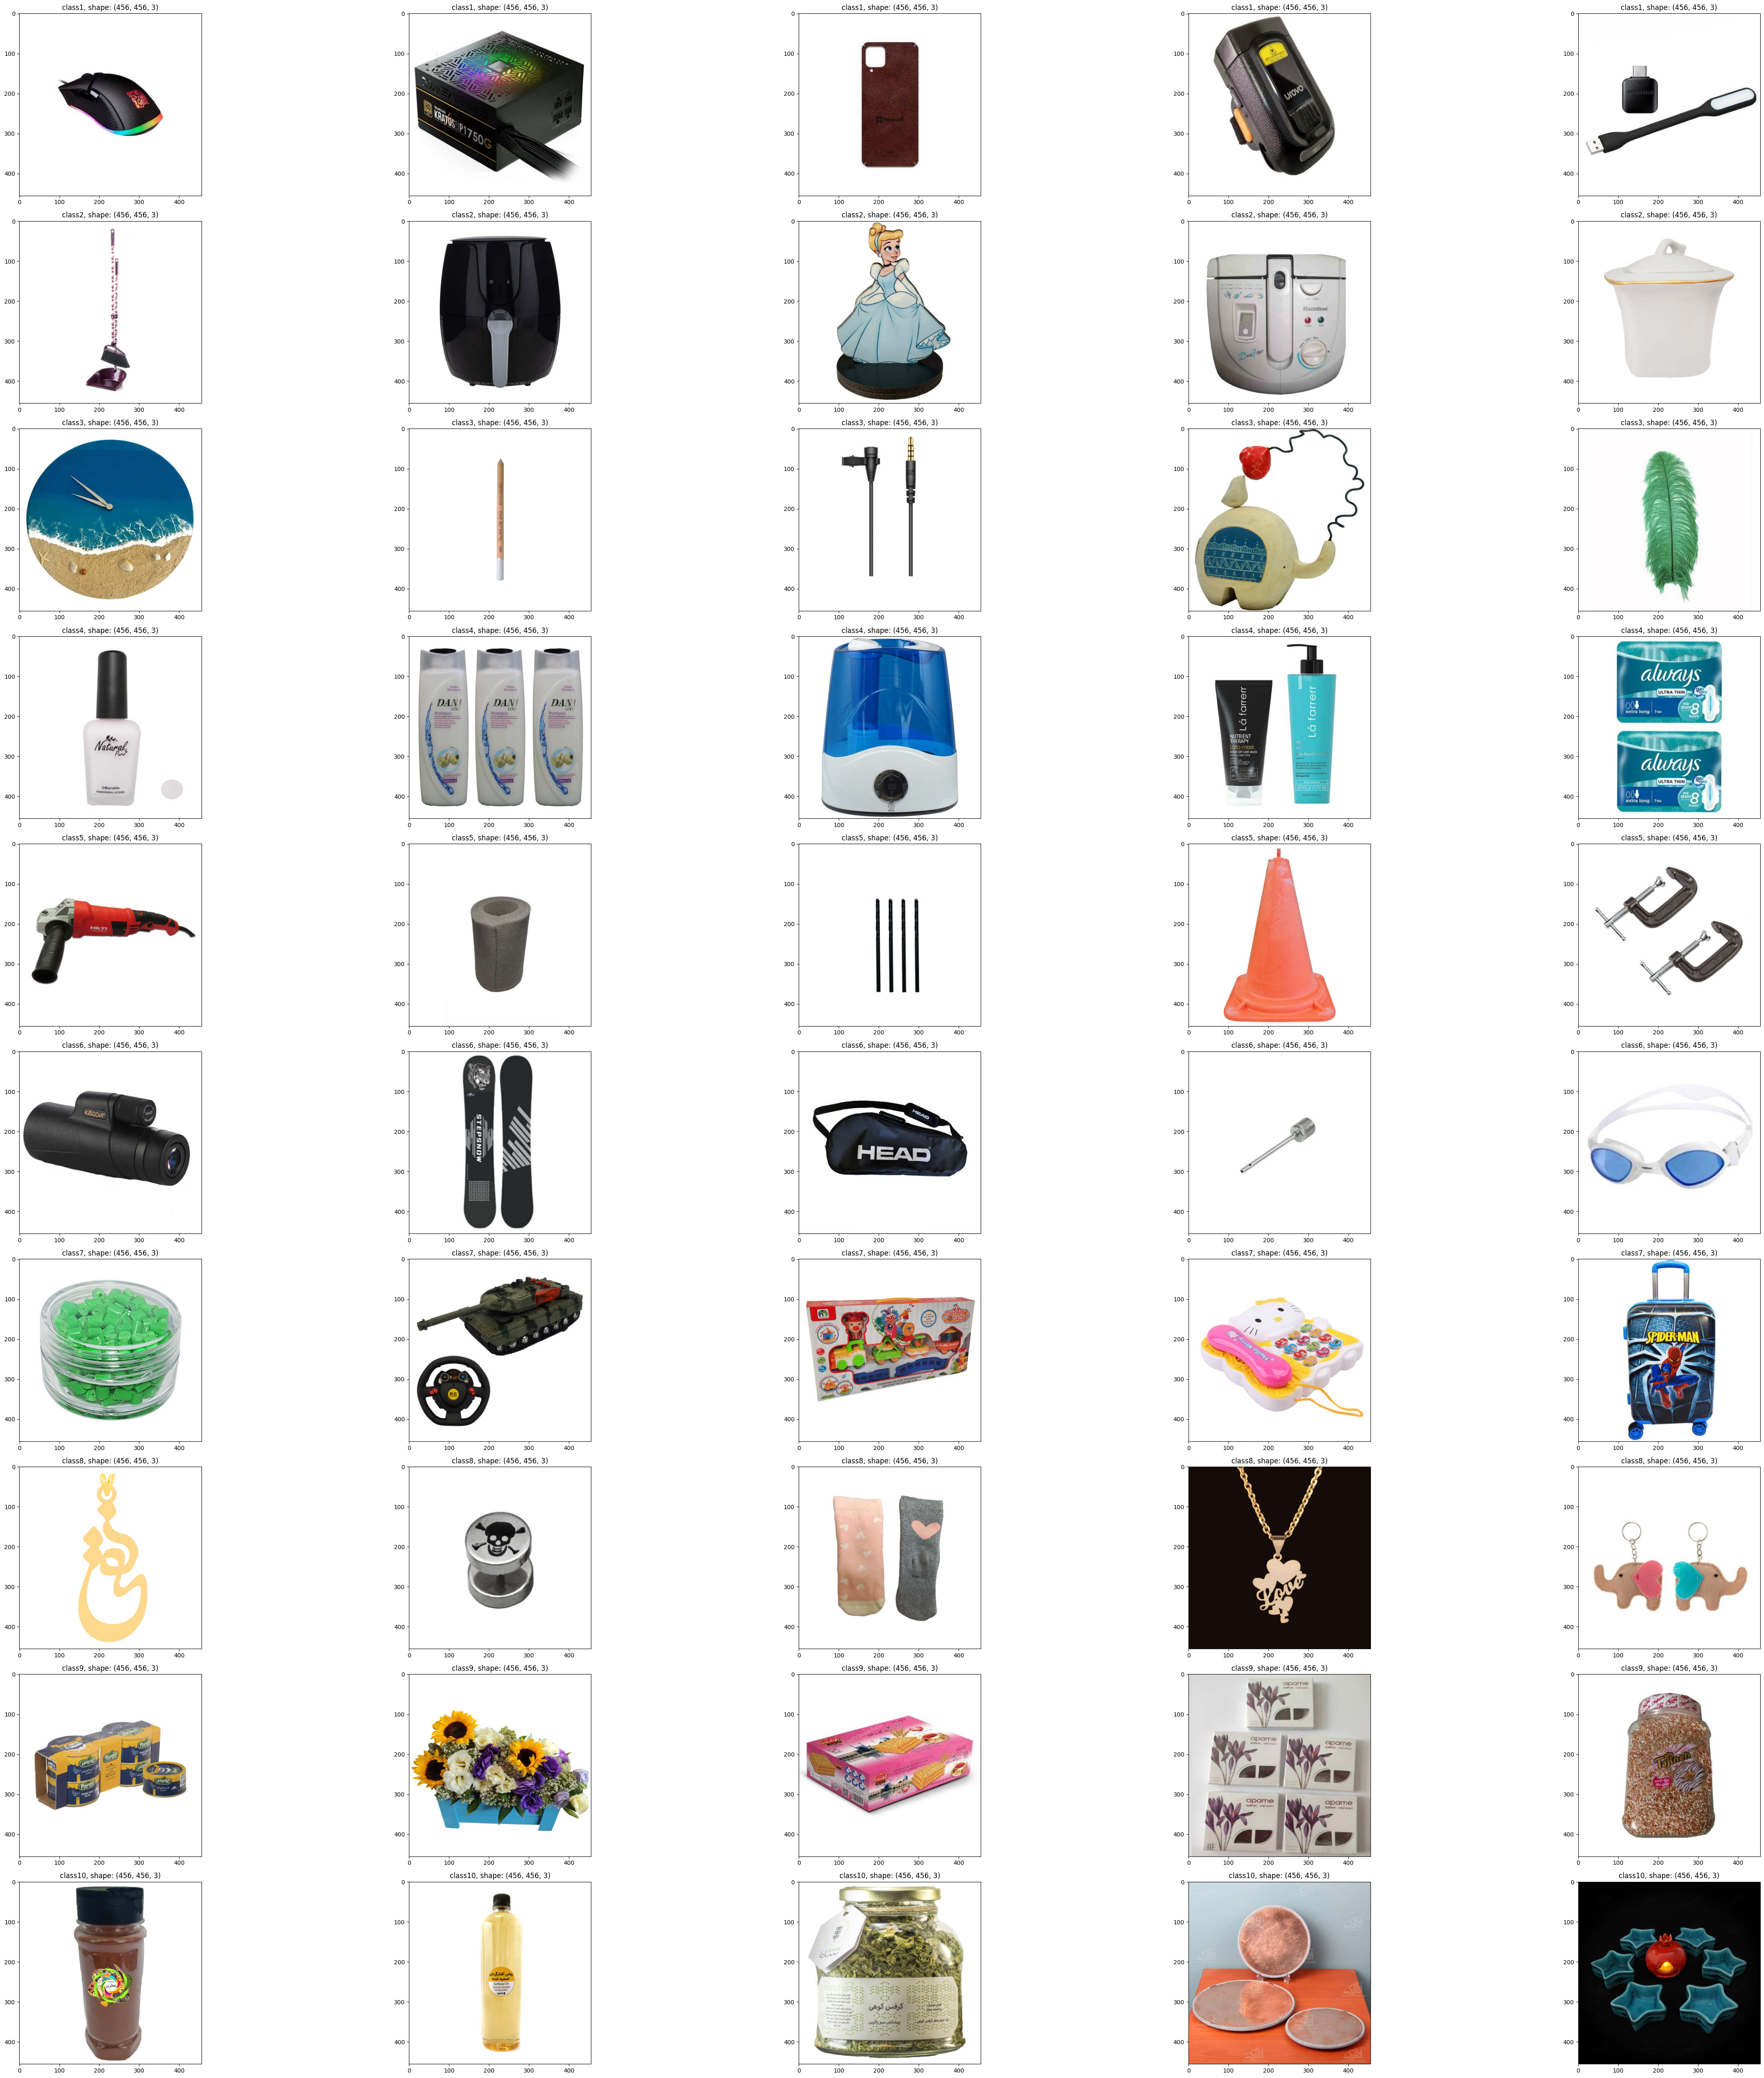

In [ ]:
data_root = pathlib.Path('train_data')
fig , ax = plt.subplots(nrows = 10 , ncols = 5 , figsize = (50 , 50))
for i in range(1 , 11):
  current_dir = data_root / f'{i}'
  files = os.listdir(current_dir)
  for j in range(5):
    random_image = os.path.join(current_dir , random.choice(files))
    img = mpimg.imread(random_image)
    ax[i-1][j].imshow(img)
    ax[i-1][j].set_title(f'class{i}, shape: {img.shape}')

plt.tight_layout()

# Data Preprocessing

In [ ]:
def data_augmentation(image , label):
  # image = tf.image.random_flip_left_right(image)
  # image = tf.image.random_flip_up_down(image)
  # image = tf.image.rot90(image , k = tf.random.uniform(shape = [] , minval = 0 , maxval= 4 , dtype = tf.int32))
  # image = tf.image.random_brightness(image , max_delta = 0.2)
  # image = tf.image.random_contrast(image , lower = 0.8 , upper = 1.2)
  # image = tf.image.random_saturation(image , lower = 0.8 , upper = 1.2)
  # image = tf.image.random_hue(image , max_delta = 0.2)

  return image , label


#train_dataset = train_dataset.map(data_augmentation , num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.map(lambda x , y:(x , tf.one_hot(y , 10)))
validation_dataset = validation_dataset.map(lambda x , y: (x , tf.one_hot(y , 10)))

#Training Model


## InceptionV3

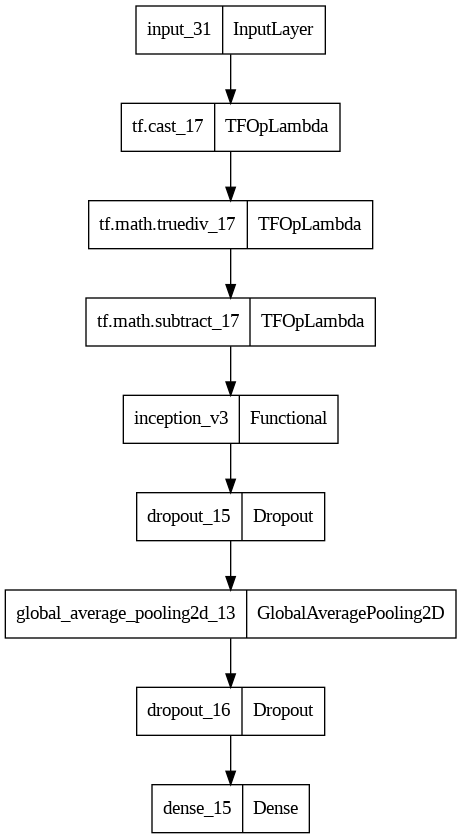

In [ ]:
from tensorflow.keras.optimizers import Adam


input_layer = tf.keras.layers.Input((224 , 224 , 3))
x = tf.cast(input_layer , tf.float32)
x = inc3(x)
inceptionv3_model = InceptionV3(include_top = False, classifier_activation = 'softmax', classes=10)(x)
inceptionv3_model = keras.layers.Dropout(0.2)(inceptionv3_model)
inceptionv3_model = GlobalAveragePooling2D()(inceptionv3_model)
inceptionv3_model = keras.layers.Dropout(0.4)(inceptionv3_model)
inceptionv3_model = Dense(10 , activation = 'softmax')(inceptionv3_model)

inceptionv3_custom_model = Model(inputs = input_layer , outputs = inceptionv3_model)
inceptionv3_custom_model.compile(optimizer = Adam(learning_rate=0.00001), loss = 'categorical_crossentropy' , metrics = [F1Score(average = 'micro')])
keras.utils.plot_model(inceptionv3_custom_model)

In [ ]:
inceptionv3_custom_model.fit(train_dataset , validation_data = validation_dataset , epochs = 100)

Epoch 1/100
250/250 [==============================] - 104s 303ms/step - loss: 2.2128 - f1_score: 0.2227 - val_loss: 1.7798 - val_f1_score: 0.3909
Epoch 2/100
250/250 [==============================] - 81s 324ms/step - loss: 1.6620 - f1_score: 0.4357 - val_loss: 1.5525 - val_f1_score: 0.4895
Epoch 3/100
250/250 [==============================] - 76s 303ms/step - loss: 1.4047 - f1_score: 0.5284 - val_loss: 1.4364 - val_f1_score: 0.5280
Epoch 4/100
250/250 [==============================] - 76s 303ms/step - loss: 1.1999 - f1_score: 0.6022 - val_loss: 1.3729 - val_f1_score: 0.5335
Epoch 5/100
250/250 [==============================] - 76s 302ms/step - loss: 1.0261 - f1_score: 0.6717 - val_loss: 1.3323 - val_f1_score: 0.5656
Epoch 6/100
250/250 [==============================] - 77s 304ms/step - loss: 0.8632 - f1_score: 0.7275 - val_loss: 1.3113 - val_f1_score: 0.5746
Epoch 7/100
250/250 [==============================] - 76s 302ms/step - loss: 0.7085 - f1_score: 0.7834 - val_loss: 1.2932 

In [ ]:
inceptionv3_custom_model.evaluate(validation_dataset)

63/63 [==============================] - 5s 75ms/step - loss: 2.1999 - f1_score: 0.6276


[2.199871778488159, 0.6276276111602783]

## EfficientNetV2B3

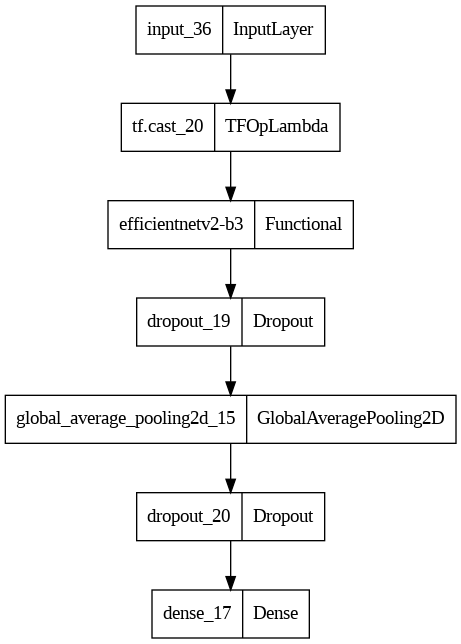

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2B3, efficientnet_v2

input_layer = tf.keras.layers.Input((224 , 224 , 3))
x = tf.cast(input_layer , tf.float32)
x = efficientnet_v2.preprocess_input(x)
efficientnet_v2_model = EfficientNetV2B3(include_top = False, classifier_activation = 'softmax', classes=10)(x)
efficientnet_v2_model = keras.layers.Dropout(0.2)(efficientnet_v2_model)
efficientnet_v2_model = GlobalAveragePooling2D()(efficientnet_v2_model)
efficientnet_v2_model = keras.layers.Dropout(0.4)(efficientnet_v2_model)
efficientnet_v2_model = Dense(10 , activation = 'softmax')(efficientnet_v2_model)

efficientnet_v2_custom_model = Model(inputs = input_layer , outputs = efficientnet_v2_model)
efficientnet_v2_custom_model.compile(optimizer = Adam(learning_rate=0.00001), loss = 'categorical_crossentropy' , metrics = [F1Score(average = 'micro')])
keras.utils.plot_model(efficientnet_v2_custom_model)

In [ ]:
efficientnet_v2_custom_model.fit(train_dataset , validation_data = validation_dataset , epochs = 100)

Epoch 1/100
250/250 [==============================] - 160s 401ms/step - loss: 2.2925 - f1_score: 0.1450 - val_loss: 2.1815 - val_f1_score: 0.2232
Epoch 2/100
250/250 [==============================] - 100s 400ms/step - loss: 2.1419 - f1_score: 0.2320 - val_loss: 2.0425 - val_f1_score: 0.3463
Epoch 3/100
250/250 [==============================] - 95s 380ms/step - loss: 2.0002 - f1_score: 0.3224 - val_loss: 1.9098 - val_f1_score: 0.4109
Epoch 4/100
250/250 [==============================] - 95s 379ms/step - loss: 1.8654 - f1_score: 0.3820 - val_loss: 1.7881 - val_f1_score: 0.4625
Epoch 5/100
250/250 [==============================] - 100s 399ms/step - loss: 1.7391 - f1_score: 0.4229 - val_loss: 1.6912 - val_f1_score: 0.4925
Epoch 6/100
250/250 [==============================] - 95s 380ms/step - loss: 1.6489 - f1_score: 0.4585 - val_loss: 1.6050 - val_f1_score: 0.5120
Epoch 7/100
250/250 [==============================] - 100s 400ms/step - loss: 1.5610 - f1_score: 0.4889 - val_loss: 1.53

# Keras CV

In [ ]:
!pip install keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 46.2 MB/s eta 0:00:00


In [ ]:
import keras_cv

Using TensorFlow backend


In [ ]:
import keras

retina_net_model = keras_cv.models.RetinaNet(
    num_classes=20,
    bounding_box_format="xywh",
    backbone=keras_cv.models.ResNet50Backbone.from_preset(
        "resnet50_imagenet"
    )
)

retina_net_model.compile(
    classification_loss='focal',
    box_loss='smoothl1',
    optimizer=keras.optimizers.SGD(global_clipnorm=10.0),
    jit_compile=False,
)

In [ ]:
retina_net_model.fit(train_dataset , validation_data = validation_dataset , epochs = 100)

NameError: ignored